In [1]:
import pandas as pd
from property_prediction import SevenNetPropertiesPreditcor
from torch_geometric.loader import DataLoader

from dataset import AtomsToGraphCollater
import sevenn

import torch.optim as optim
import torch.nn as nn
from train import train
from nn import SimplePeriodicNetwork


df = pd.read_csv('sevennet_slopes.csv')
# df.loc[df['v1_Li_slope'] <= 0, 'v1_Li_slope'] = 1e-4  #### WRONG!!!
df["v1_Li_slope"] = df["v1_Li_slope"].clip(lower=1e-4)

from dataset import build_dataset
dataset = build_dataset(df, temp = 1000)

Cache path set to "./cache". To change, set PFP_CACHE environment variable.


100%|██████████| 179/179 [00:00<00:00, 1228.66it/s]


In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

train_indices, val_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)

train_dataset = [dataset[i] for i in train_indices]
val_dataset = [dataset[i] for i in val_indices]

batch_size = 10

In [9]:
# why do we need these sevenn intrinsics exposed? can't we just initialize SevenNetPropertiesPreditcor from checkpoint name?

checkpoint = sevenn.util.pretrained_name_to_path('7net-0')
sevennet_model, sevennet_config = sevenn.util.model_from_checkpoint(checkpoint)


In [10]:
sevennet_predictor = SevenNetPropertiesPreditcor(sevennet_model = sevennet_model, sevennet_config = sevennet_config)

In [11]:
# dummy_dataloader = DataLoader(train_dataset[:1], batch_size=1)
# dummy_dataloader.collate_fn = AtomsToGraphCollater(cutoff = 5, noise_std=0.1, properties_predictor = sevennet_predictor)

# dummy_samples = [next(iter(dummy_dataloader)) for _ in range(20)]
# import matplotlib.pyplot as plt
# dummy_coords = np.stack([d["pos"].reshape(-1) for d in dummy_samples])
# for coord in dummy_coords.T:
#     plt.plot(coord - coord[0], color="blue", alpha=0.1);
# plt.plot((dummy_coords - dummy_coords[0]).std(axis=1), color='k', linewidth=2);

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
train_dataloader.collate_fn = AtomsToGraphCollater(cutoff = 5, noise_std=0.01, properties_predictor = sevennet_predictor)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
val_dataloader.collate_fn = AtomsToGraphCollater(cutoff = 5, noise_std=0.01, properties_predictor = sevennet_predictor)

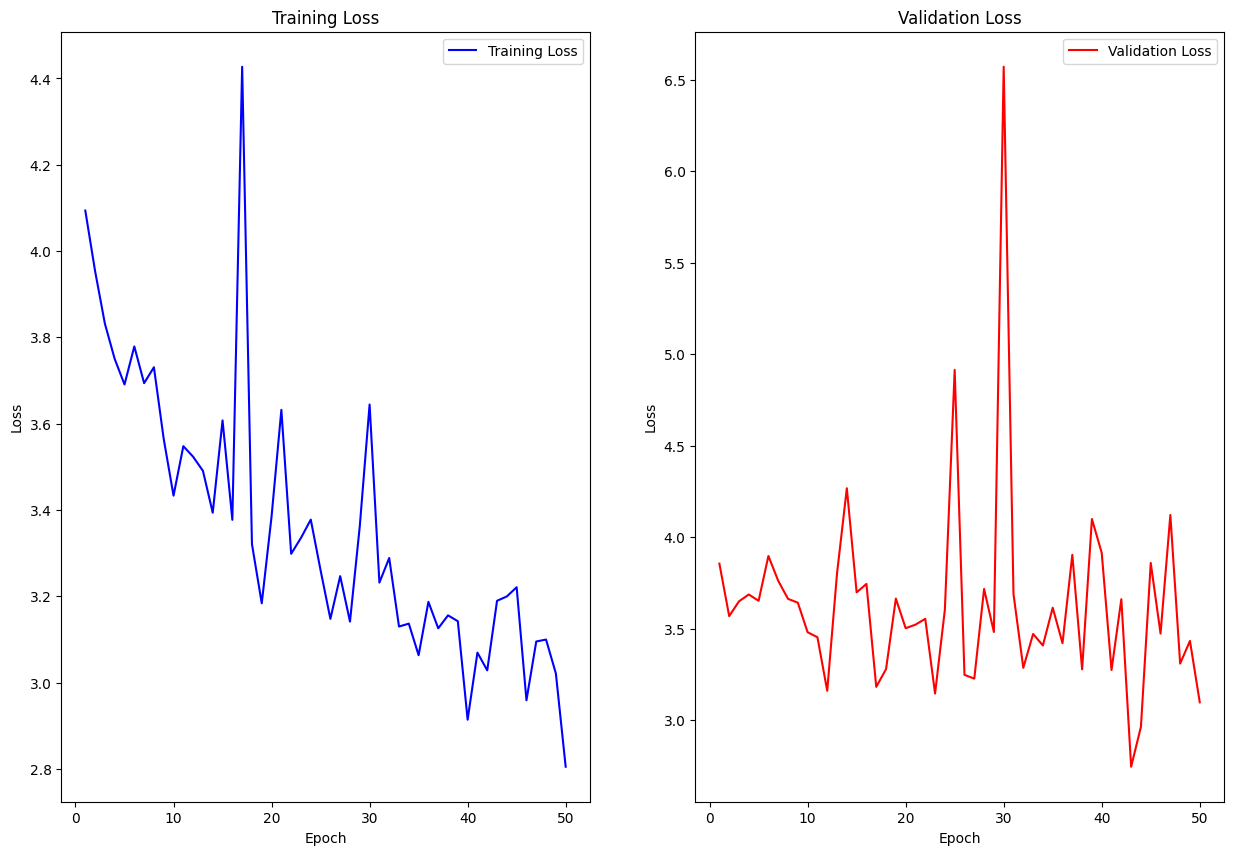

In [13]:
radial_cutoff = 5

net = SimplePeriodicNetwork(
    irreps_in="1x1o",  
    irreps_out="1x0e",  # Single scalar (L=0 and even parity) to output (for example) energy
    max_radius=radial_cutoff, # Cutoff radius for convolution
    num_neighbors=10.0,  # scaling factor based on the typical number of neighbors
    pool_nodes=True,  # We pool nodes to predict total energy
)

criterion = nn.MSELoss()  # Example: Mean Squared Error
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.RMSprop(net.parameters(), lr=0.000001)

num_epochs = 50

train(net, train_dataloader, val_dataloader, optimizer, criterion, num_epochs)

In [ ]:
dummy_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
dummy_dataloader.collate_fn = AtomsToGraphCollater(cutoff = 5, noise_std=0.1, properties_predictor = sevennet_predictor)
dummy_data = [
    next(iter(dummy_dataloader)) for _ in range(1)
]

In [9]:
forces = np.stack([d.x.numpy() for d in dummy_data], axis=0)

In [ ]:
forces.shape

In [ ]:
import matplotlib.pyplot as plt
plt.hist(forces.reshape(-1), bins=100)
plt.yscale("log");

In [ ]:
plt.hist(dummy_data[0].target.numpy(), bins=100);

In [ ]:
np.log10(1e-4)

In [ ]:
plt.hist([d.x["log_diffusion"] for d in dataset], bins=100);